# Introduction to RAG chatbot

Now we can combine knowledge we get from the two previous notebooks in this module:
* from the first one we will take
    - **memory persistence** - this is an important part of production chat bots. For customer applications we want not only preserve messages during ongoing conversation, but also store them long term. It may be useful for multiple purposes:
        * to start the conversation at any time in the future from the point where we left off
        * for security and compliance reasons
        * to collect the data for fine-tuning of the model, etc.
* from the second notebook we will reuse our **RAG application**.


Using these tools we will build RAG chatbot with memory that will be capable to classify user intent and create branches in our conversation flow.  
It will be a simple example of a chatbot that can answer casual questions or retrieve scientific papers from vector storage.  
Although concepts that we use here are quite simple, the potential of this architecture and its' different variations is huge. 

For that purpose we will use langgraph implementation because it is the most recent one.  
There are other ways how we can build application with the same functionality using pure langchain, e.g. [this one](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html#runnablewithmessagehistory).

Generally, implementation of a RAG depends heavily on your existing architecture and stack used, business requirements and SLAs.


In [181]:
import os
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent.parent))

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from src.loader import ArticleLoader
from src.retriever import ArticleRetriever

from langchain_chroma import Chroma
import glob
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool, render_text_description_and_args
from langchain_core.messages import SystemMessage
from uuid import uuid4
from IPython.display import display, Markdown

llm = ChatOpenAI(model='gpt-4o-mini')

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

persist_directory = 'docs/chroma/'
JSON_DIR = "../dataset_doc/train"

print(f"OpenAI API Key Loaded: {'OPENAI_API_KEY' in os.environ and bool(os.environ.get('OPENAI_API_KEY'))}")
print(f"LLM Model Name: {llm.model_name}")
print(f"Embeddings Model Name: {embeddings_model.model}")

OpenAI API Key Loaded: True
LLM Model Name: gpt-4o-mini
Embeddings Model Name: text-embedding-3-small


### `math_retriever` tool

Let's load some articles from doc_bank dataset.  
Instantiate `Chroma` and our `retriever`.  
We will utilize the retriever we've implemented before.

We will select a small subset of documents and index them.  
Note that we set k=1, so we will use only the top retrieved document to generate answers.

In [182]:
articles_list = [os.path.basename(dir) for dir in glob.glob(f"{JSON_DIR}/*")[:20]]

documents = []

for article_path in articles_list:
    article_path = Path(JSON_DIR, article_path).resolve(strict=True)
    loader = ArticleLoader(article_path)
    docs = loader.load()
    documents.extend(docs)

vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings_model,
    persist_directory=persist_directory
)
retriever = ArticleRetriever(
    vectordb=vectordb,
    k=1
)

Now, getting to actual RAG-based chatbot implementation.

First, lets create a graph builder object from langgraph (`StateGraph`) and put [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) inside it.  
`MessagesState` is an object that will hold all the messages that pass throught the conversationgraph together with all their metadata, e.g.: 
* type of the message (`HumanMessage`, `AIMessage`, `ToolMessage`)
* token usage
* all unique ids, etc.


In [183]:
graph_builder = StateGraph(MessagesState)

Then we create a function `math_retriever` that will use our `retriever` for obtaining document chunks.  
We will use [`@tool`](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html#tool) wrapper from langchain and specify that the function should return content together with artifacts.  
Note that this is an alternative to `StructuredTool` we used in the first Notebook.

Notice here that docstring that we add to a function will be used for the annotation of the tool and LLM agent will decide whether to use this tool based on this annotation. Thus it's important to annotate it properly.

In [184]:
@tool(response_format="content_and_artifact")
def math_retriever(query: str):
    """Retrieve information related to a math query from indexed scientific papers."""
    # Use the public invoke method which handles callbacks correctly
    retrieved_docs = retriever.invoke(query)

    # Serialize the document content and metadata for the LLM
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    # Return serialized string and the original documents as artifacts
    return serialized, retrieved_docs

We generated a tool with the name `math_retriever`.  
Note how we've got a StructuredTool utilizing the `@tool` decorator.

In [185]:
type(math_retriever)

langchain_core.tools.structured.StructuredTool

In [186]:
math_retriever.name

'math_retriever'

In [187]:
render_text_description_and_args([math_retriever]) 

"math_retriever(query: str) - Retrieve information related to a math query from indexed scientific papers., args: {'query': {'title': 'Query', 'type': 'string'}}"

### Conditional node `query_or_respond` (it splits conversation graph into branches)

Next we create a function that will be the conditional node in our graph and will bind the tool (make the dialog flow going through retrieval) in case LLM decide to use the tool.

It's important to remeber that this this function will generate a `tool_call` event (`AIMessage`) in the `MessagesState`. Thus, it will decide which way the conversation will go. 

The function's docstring here is very important as it gives LLM instruction when to use the tool and when not to.  
That's why it's important to write the docstring properly.  
For instance, it's better to specify exact name of the tool to be called and exact conditions when it needs to be called.

In [188]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for `math_retriever` if user question pertains various branches of math; 
    Respond in case user says something casual"""
    llm_with_tools = llm.bind_tools([math_retriever])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

### `tools` object

Then we create a set of tools using pre built LangGraph component, [`ToolNode`](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/?h=tool#how-to-call-tools-using-toolnode).  
It will execute the `tool_call` made by `query_or_respond` and will add tool response (`ToolMessage`) to the `MessageState`.

In [189]:
# Step 2: Execute the retrieval.
tools = ToolNode([math_retriever])

Notice below, if we list tools by name. We have our `retrieve` tool together with the description from the docstring

In [190]:
tools.tools_by_name

{'math_retriever': StructuredTool(name='math_retriever', description='Retrieve information related to a math query from indexed scientific papers.', args_schema=<class 'langchain_core.utils.pydantic.math_retriever'>, response_format='content_and_artifact', func=<function math_retriever at 0x000002601A586200>)}

### `generate` function

Next, we create a function that will generate the answer on the question using retrieved documents.

In [191]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    message_content = state["messages"][-1].content

    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{message_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

### Compiling the `graph`

Now, as we have all the nodes ready let's build the graph

First, let's create nodes `query_or_respond`, `tools`, and `generate`.

In [192]:
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

Now, we create conditional edge for `query_or_respond` node. 
There are 2 options: 
* to call available tools or
* to `END` conversation, current interaction with the user which means to return an answer right away. 

In [193]:
graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)

We connect nodes `tools` with `generate`, and `generate` with `END` respectively.

In [194]:
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

Finally we compile the graph and as chekpoint use `MemorySaver` object.
You can read about this object in details [in Langgraph documentation](https://langchain-ai.github.io/langgraph/concepts/persistence/).

For now let's just remember that it creates a memory flow and appends snapshots of `MessagesState` after every single change in it, i.e. after adding of `HumanMessage`, `AIMessage`, `ToolMessage` etc.  
Thus, the number of snapshots will be growing faster than the number of `HumanMessage`.

In [195]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": str(uuid4())}}

Let's visualize the graph

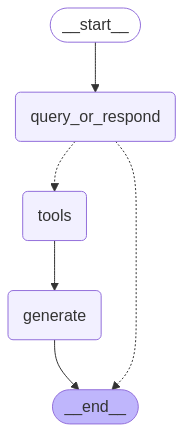

In [196]:
graph

### Test

Let's try out our chatbot. First, let's greet it.

In [197]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config 
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


It answered right away without any additional tool calls. Now, let's ask it some complex question.

In [198]:
input_message = "Within Math Game Theory what are the games with ﬁrst-mover advantage?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config 
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Within Math Game Theory what are the games with ﬁrst-mover advantage?
================================== Ai Message ==================================
Tool Calls:
  math_retriever (call_m77hrVAk8lo7p6h2JB8gI0Ku)
 Call ID: call_m77hrVAk8lo7p6h2JB8gI0Ku
  Args:
    query: first-mover advantage in game theory
================================= Tool Message =================================
Name: math_retriever

Source: {'abstract': ' We propose a framework for generating a signal\n control policy for a trafﬁc network of signalized intersections to\n accomplish control objectives expressible using linear temporal\n logic. By applying techniques from model checking and formal\n methods, we obtain a correct-by-construction controller that is guaranteed to satisfy complex speciﬁcations. To apply these\n tools, we identify and exploit structural properties particular\n to trafﬁc networks that allow for efﬁcient co

As you can see from our question it generated a query fro `retrieve` function and executed a vector database search. In the end it generated answer using retrieved chunks. 

Let's ask another complex question.

In [199]:
input_message = "What is stochastic optimal control problems?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config 
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is stochastic optimal control problems?
================================== Ai Message ==================================
Tool Calls:
  math_retriever (call_0jKp5efl3QtMUEOaQo8wMENr)
 Call ID: call_0jKp5efl3QtMUEOaQo8wMENr
  Args:
    query: stochastic optimal control problems
================================= Tool Message =================================
Name: math_retriever

Source: {'abstract': ' Using stochastic geometry, we develop a tractable\n uplink modeling paradigm for outage probability and spectral\n efﬁciency in both single and multi-tier cellular wireless networks.\n The analysis accounts for per user equipment (UE) power\n control as well as the maximum power limitations for UEs. More speciﬁcally, for interference mitigation and robust uplink\n communication, each UE is required to control its transmit power\n such that the average received signal power at its serving base\n station (B

Same behavior as for the previous question.

Now, finally let's test how the memory works and ask the chatbot to combine two previous answers from our conversation.

In [200]:
input_message = "Combine your answers on my first and last questions into one"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Combine your answers on my first and last questions into one
================================== Ai Message ==================================

In game theory, games with a first-mover advantage are those in which the initial player can make a strategic move that significantly influences the outcome. The first mover often establishes a favorable position, dictating the pace and direction of the game, thus forcing the second player into a reactive strategy. Examples include extensive form games like chess and tic-tac-toe, where the first player can commit to a strategy that may lead to a better payoff based on subsequent players' responses.

On the other hand, stochastic optimal control problems involve making decisions in uncertain environments over time, where outcomes are influenced by random variables. In these problems, the goal is to identify a control policy that either minimizes costs or maximizes r

It succeeded, note again, that it didn't use tools for answering this question.

### In-depth tech details on how snapshots look like

If you are interested in nitty-gritty of how memory checkpoints work, you can retrieve them from memory object and look into individual ones.

In [201]:
checkpoints = list(memory.list(config=config))

If to start unravel them from the end, the last message will be the first one in our conversation.

In [202]:
checkpoints[-1].checkpoint["channel_values"]

{'__start__': {'messages': [{'role': 'user', 'content': 'Hello'}]}}

The third from the end is the first answer to us from AI. 

As you can see each checkpoint contains the whole snapshot of all the previous interactions with the chat.

In [203]:
checkpoints[-3].checkpoint["channel_values"]

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='134e092d-84ac-47b6-9122-fa7c2e255134'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 52, 'total_tokens': 63, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BJXuRSBONvheY2SeHyaHlsQnYXrRk', 'finish_reason': 'stop', 'logprobs': None}, id='run-04d0bde9-8b1d-4bc8-8a57-aa70c5a02cc8-0', usage_metadata={'input_tokens': 52, 'output_tokens': 11, 'total_tokens': 63, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

The seventh from the end will already contain a `tool_call` and tool response as `ToolMessage`. And so on...

In [204]:
checkpoints[-7].checkpoint["channel_values"]

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='134e092d-84ac-47b6-9122-fa7c2e255134'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 52, 'total_tokens': 63, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BJXuRSBONvheY2SeHyaHlsQnYXrRk', 'finish_reason': 'stop', 'logprobs': None}, id='run-04d0bde9-8b1d-4bc8-8a57-aa70c5a02cc8-0', usage_metadata={'input_tokens': 52, 'output_tokens': 11, 'total_tokens': 63, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='Within Math Game Theory what are th

# Task

Recreate existing state graph and 
* Add to tools Wikipedia Search from Langchain
* Make it work in a way so that when a **question on math** comes, LLM makes tool call to **`math_retriever`** but when the question is about **historical figures** let it **calls Wikipedia**.

In [205]:
# You will require all imports from the top of the notebook to proceed as well as functions `generate`

from langchain_community.tools import WikipediaQueryRun

Check the documentation on how to correctly instantiate [`WikipediaQueryRun`](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.wikipedia.tool.WikipediaQueryRun.html)

Hint: check the default description attribute of `WikipediaQueryRun` object.  
You will see that it's quite generic and suggest to use the tool for any kind of queries.  
That may confuse LLM what tool to use. As we want to narrow down the use of `wiki_tool` to **only particular cases of historical figures**, modify the description attribute when you instantiate it.  

In [206]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# Configure the underlying API wrapper for concise results
wiki_api_wrapper = WikipediaAPIWrapper(
    top_k_results=1,                 # Fetch only the top result
    doc_content_chars_max=2000       # Limit the summary length
)

# Instantiate the tool with a specific name and description
wiki_tool = WikipediaQueryRun(
    name="wikipedia_historical_figures",
    description=(
        "Use this tool ONLY for questions about specific historical figures (people from the past). "
        "Input should be ONLY the full name of the historical person."
    ),
    api_wrapper=wiki_api_wrapper
)

# Optional: Print to verify
print(f"Tool Name: {wiki_tool.name}")
print(f"Tool Description: {wiki_tool.description}")

Tool Name: wikipedia_historical_figures
Tool Description: Use this tool ONLY for questions about specific historical figures (people from the past). Input should be ONLY the full name of the historical person.


Modify existing function `query_or_respond` adding additional option of calling Wikipedia **in case the question is about historical figures.**  
For that you will need: 
* to add instantiated `wiki_tool` to the list of tools
* change function docstring, adding additional instruction for the new tool

Hint: As Wikipedia search is pretty straightforward (to work well it requires exact page names to be provided as query to the tool), include in your `wiki_tool` instruction an **ask to extract from the user's message only the name of the person and nothing else**. 

Also, we don't expect that it will answer deep questions about people because in Langchain Wiki search the result is only page summary.  
We will test on some simple question, e.g. when is person's birthday.  

In [207]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage
# Assuming 'llm' and 'math_retriever' are already defined and accessible from the notebook's scope.
# Assuming 'wiki_tool' was just defined in the previous cell.

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_retiever_or_wiki_or_respond(state: MessagesState):
    """
    Decision node: Determines whether to use a tool or respond directly.

    - If the user asks a question related to MATH or GAME THEORY, call the 'math_retriever' tool.
    - If the user asks a question about a specific HISTORICAL FIGURE, call the 'wikipedia_historical_figures' tool
      with ONLY the person's full name as input.
    - Otherwise, respond directly without using tools (e.g., for casual conversation).
    """
    # Define the list of tools available at this decision point
    available_tools = [math_retriever, wiki_tool]

    # Bind these tools to the LLM, so it knows it *can* use them
    llm_with_tools = llm.bind_tools(available_tools)

    # Get the current conversation history from the state
    messages = state["messages"]

    # Invoke the LLM. Based on the conversation history and the function's
    # docstring (acting as a system prompt of sorts), the LLM will decide
    # whether to respond directly or call one of the bound tools.
    response = llm_with_tools.invoke(messages)

    # Return the AIMessage, potentially containing tool calls
    return {"messages": [response]}

Don't forget to add `wiki_tool` to the list of actual tools to be called

In [208]:
from langgraph.prebuilt import ToolNode

# Assuming 'math_retriever' and 'wiki_tool' are defined in the notebook scope

# Create the ToolNode, providing it with the list of tools it should be able to execute.
# This node will process the AIMessage from the previous step. If the AIMessage
# contains tool calls, this node will execute the corresponding tool functions.
tools_node = ToolNode([math_retriever, wiki_tool])

# Optional: Print the names of the tools recognized by this node
print(f"Tools registered in ToolNode: {list(tools_node.tools_by_name.keys())}")

Tools registered in ToolNode: ['math_retriever', 'wikipedia_historical_figures']


Rebuild the graph.  
It's going to look almost the same as it was before, only replace the node with `query_or_respond` with your new conditional tool calling function.

LangGraph graph built and compiled successfully.


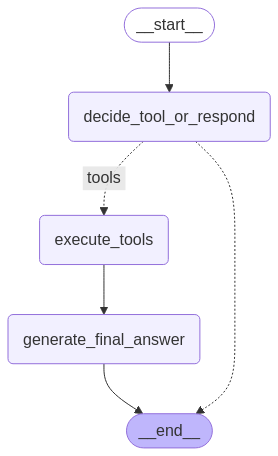

In [209]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition # Import the condition function
from uuid import uuid4

# Assuming 'generate' function is defined earlier in the notebook scope
# Assuming 'query_retiever_or_wiki_or_respond' and 'tools_node' are defined from previous cells

graph_builder = StateGraph(MessagesState)

# Add the nodes to the graph builder
graph_builder.add_node("decide_tool_or_respond", query_retiever_or_wiki_or_respond)
graph_builder.add_node("execute_tools", tools_node)
graph_builder.add_node("generate_final_answer", generate) # Assuming 'generate' is defined

# Set the entry point for the graph
graph_builder.set_entry_point("decide_tool_or_respond")

# Define the conditional routing from the decision node
graph_builder.add_conditional_edges(
    "decide_tool_or_respond",  # Source node
    tools_condition,           # Condition check (did the LLM call a tool?)
    {
        "tools": "execute_tools", # If condition returns "tools", go to execute_tools node
        END: END                   # If condition returns END, finish the graph execution
    },
)

# Define the standard edges for the RAG/Tool path
graph_builder.add_edge("execute_tools", "generate_final_answer")
graph_builder.add_edge("generate_final_answer", END)

# Configure memory for persisting conversation state
memory = MemorySaver()

# Compile the graph definition into a runnable application
graph = graph_builder.compile(checkpointer=memory)

# Specify a unique ID for the conversation thread for memory tracking
config = {"configurable": {"thread_id": str(uuid4())}}

print("LangGraph graph built and compiled successfully.")
# Optional: Visualize the graph if libraries are installed
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization requires additional libraries (e.g., pygraphviz).")
    pass

### Test it

In [210]:
input_message = "When is Benjamin Franklin birtday?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config 
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

When is Benjamin Franklin birtday?
================================== Ai Message ==================================
Tool Calls:
  wikipedia_historical_figures (call_cN7iDwUU4zaton07gYLwY4Fg)
 Call ID: call_cN7iDwUU4zaton07gYLwY4Fg
  Args:
    query: Benjamin Franklin
================================= Tool Message =================================
Name: wikipedia_historical_figures

Page: Benjamin Franklin
Summary: Benjamin Franklin (January 17, 1706 [O.S. January 6, 1705] – April 17, 1790) was an American polymath: a writer, scientist, inventor, statesman, diplomat, printer, publisher and political philosopher. Among the most influential intellectuals of his time, Franklin was one of the Founding Fathers of the United States; a drafter and signer of the Declaration of Independence; and the first postmaster general.
Born in the Province of Massachusetts Bay, Franklin became a successful newspaper editor an

In [211]:
input_message = "Within Math Game Theory what are the games with ﬁrst-mover advantage?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config 
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Within Math Game Theory what are the games with ﬁrst-mover advantage?
================================== Ai Message ==================================
Tool Calls:
  math_retriever (call_yX8sZ2AgtZ1hf5QoZkvlEN7p)
 Call ID: call_yX8sZ2AgtZ1hf5QoZkvlEN7p
  Args:
    query: games with first-mover advantage in game theory
================================= Tool Message =================================
Name: math_retriever

Source: {'abstract': ' We consider the problem of identifying a subset of nodes in a network that will enable the fastest spread of information in a decentralized environment.In a model of communication based on a random walk on an undirected graph, the optimal set over all sets of the same or smaller cardinality minimizes the sum of the mean ﬁrst arrival times to the set by walkers starting at nodes outside the set. The problem originates from the study of the spread of information or conse

In [212]:
input_message = "How can be person form my first question be linked to answer on the second question?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How can be person form my first question be linked to answer on the second question?
================================== Ai Message ==================================

Benjamin Franklin, known for his contributions as a statesman and diplomat, can be indirectly linked to the concept of first-mover advantage in game theory through his strategic thinking and negotiation skills. 

1. **Strategic Decision-Making**: Franklin's ability to navigate complex political environments and make early, calculated decisions can be analogous to the first-mover advantage in game theory, where the first player can dictate the game's direction and force the opponent to respond.

2. **Bargaining and Diplomacy**: Franklin's diplomatic efforts, particularly during the American Revolution, involved securing alliances and engaging in negotiations where being the first to propose terms could lead to more favorable outcomes—similar 